In [3]:
# Styling notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("rise.css", "r").read()
    return HTML(styles)
css_styling()

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../input\1_gFC2bTg3uihp1klknWU0qg.gif
../input\airline_passengers.csv
../input\graph.png
../input\holt winter.png
../input\Holt-winter additive.png
../input\Holt-winter single exponential smoothing.png
../input\macrodata.csv
../input\sample_data.csv
../input\Space_Corrected.csv
../input\timeseries_data2.xlsx
../input\Weather Station Locations.csv
../input\.ipynb_checkpoints\time-series-prediction-tutorial-with-eda-checkpoint.ipynb
../input\AirQualityUCI\AirQualityUCI.csv
../input\AirQualityUCI\AirQualityUCI.xlsx
../input\demand_store_forecast\train.csv
../input\operations\operations.csv
../input\Summary of Weather\Summary of Weather.csv


# Introduction

In this kernel, the essentials of the time series analysis is demonstrated. The datasets used is the US macroeconmic data and Store data.  

- Error, Trend and Seasonality Decomposition using Statsmodels Seasonal Decomposition
- Exponential Smoothing using Pandas EWMA and Holt Winters method for Single, Double and Triple Exponential           Smoothing
- Forecast into the real future using Holt Winters triple exponential method

Credit Source: <a> link: "https://www.kaggle.com/prakharprasad/smoothing-holt-winters-forecast/data?select=macrodata.csv" </a>

## Part I - Time Series Decomposition

### Import Libraries
Note the statsmodels specific libraries used in this kernel. 
  

In [5]:
# arrays and dataframes
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# time series - statsmodels
from statsmodels.tsa.filters.hp_filter import hpfilter  # Hodrick Prescott filter for cyclic & trend separation
from statsmodels.tsa.seasonal import seasonal_decompose # Error Trend Seasonality decomposition

# holt winters 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   # single exponential smoothing as in ewm of pandas
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing

# consistent plot size wherever not specifiied
from pylab import rcParams
rcParams['figure.figsize'] = (15,8)

In [6]:
# US Macro economic data
usmacro = pd.read_csv('../input/macrodata.csv',index_col=0,parse_dates=True)

In [7]:
usmacro.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


Any of the columns can be explored and used for time series analysis. But first we will visualize one of the columns - realgdp

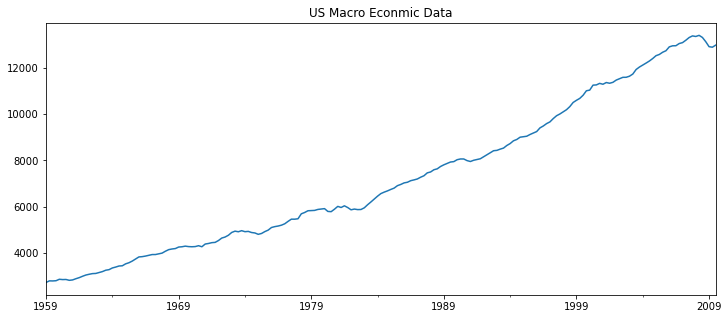

In [8]:
# visualize the realgdp --- > will use the capabilities of pandas plotting capability
usmacro['realgdp'].plot(figsize=(12,5),title='US Macro Econmic Data').autoscale(axis='x',tight=True)

Now we have the GDP trend which is sensitive to the long term fluctuations and not to the short term fluctuations. This makes more sense for analysing the business life cycle over a well defined period. Similarly, the trend can be analyzed by varying the values of lambda to check for annual and monthly trend. 

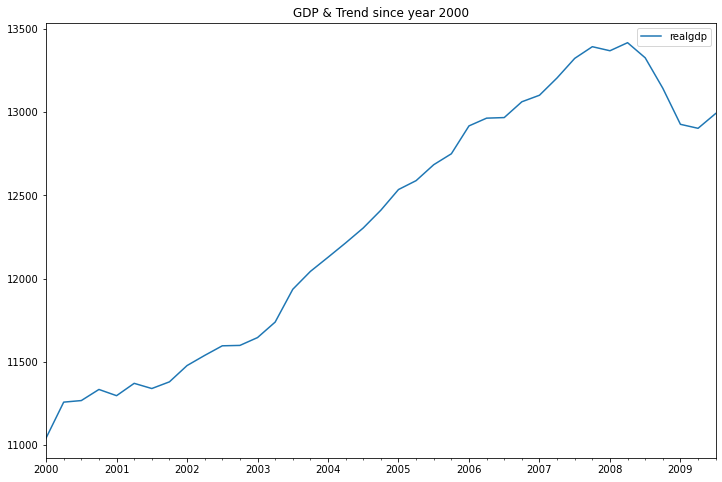

In [9]:
# Lets check this out since year 2000
usmacro[['realgdp']]['2000-03-31':].plot(figsize=(12,8),title='GDP & Trend since year 2000').autoscale(axis='x',tight=True);

In [10]:
# decompose the time series for us gdp
gdp_decompose = seasonal_decompose(usmacro['realgdp'], model = 'multiplicative')

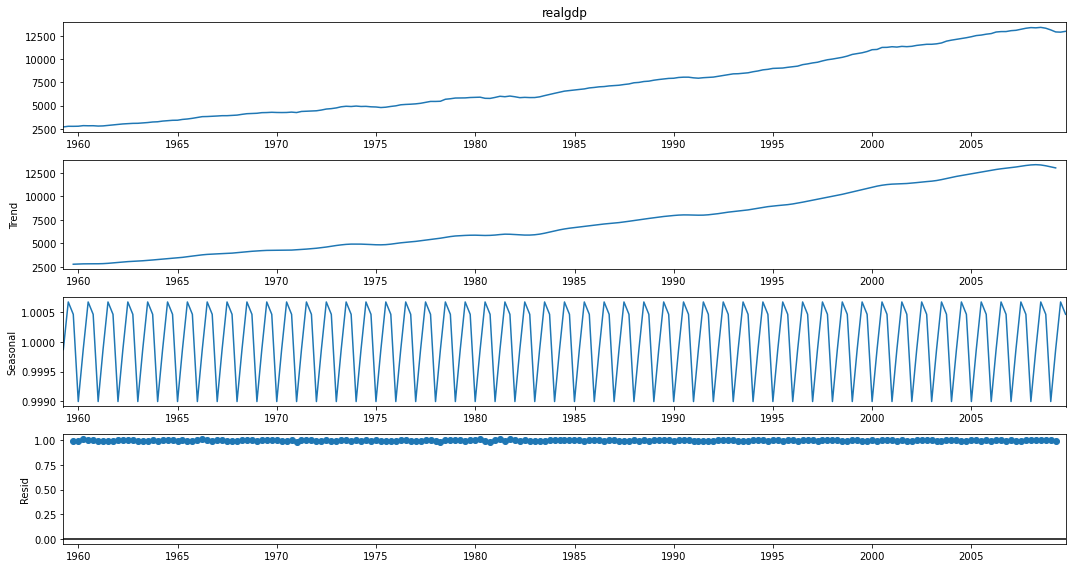

In [11]:
fig = gdp_decompose.plot()
plt.show()

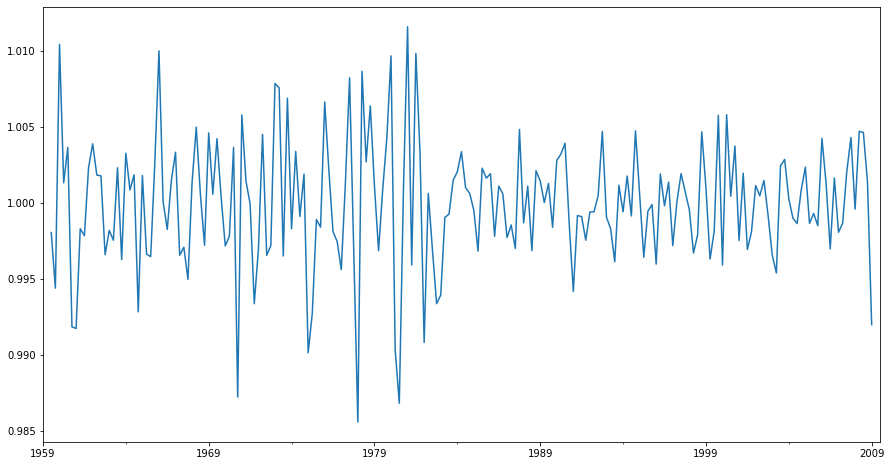

In [12]:
resid = gdp_decompose.resid.plot()

## ETS - Error, Trend and Seasonality Decomposition

The decomposition of a time series attempts to isolate individual components such as error, trend and seasonality. `Statsmodels` provided *seasonal decomposition* tool to separate out the different components. <p> To demonstrate the seasonal decomposition capability of statsmodels, I will make use of the airline passenger data.

Remember - Additive model is used when the trend component is more constant over time. Example, every year 20,000 passengers are added. Multiplicative model is used when the trend increases/decreases at a non linear rate. example, every year the number of airline passengers doubles by 20,000.

In [13]:
airline = pd.read_csv('../input/airline_passengers.csv', index_col='Month', parse_dates=True)

In [14]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [15]:
airline['Thousands of Passengers']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Thousands of Passengers, Length: 144, dtype: int64

In [16]:
# decompose the time series
decompose_result = seasonal_decompose(airline['Thousands of Passengers'],model='multiplicative')

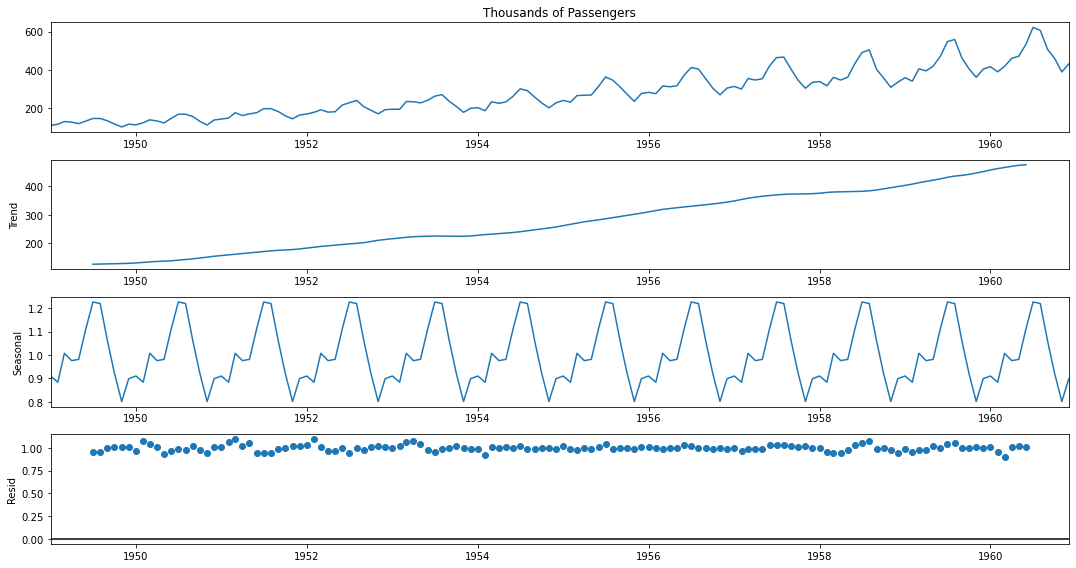

In [17]:
fig = decompose_result.plot()
plt.show()

Tip: Sometimes, the plot gets plotted twice. To get rid of this, just use a semi-colon at the end of the plot. 

So here we see the original graph, the trend, seasonal and the residual or the error.

# Part II - Fit various smoothing models to existing data


<br>

<div style="font-size:4em; text-align:center; margin-bottom:30px; color:#00746E"><b>UNIVARIATE</b></div>

In [18]:
# Let's use the Store dataset which contains the sales of items in multiple stores. 
store = pd.read_csv("../input/demand_store_forecast/train.csv", parse_dates = True, index_col = 'date')
store.head() 

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [19]:
data = store.copy()
data.index #DateTime index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=913000, freq=None)

In [20]:
data.item.value_counts() #Number of sales per item

1     18260
38    18260
28    18260
29    18260
30    18260
31    18260
32    18260
33    18260
34    18260
35    18260
36    18260
37    18260
39    18260
2     18260
40    18260
41    18260
42    18260
43    18260
44    18260
45    18260
46    18260
47    18260
48    18260
49    18260
27    18260
26    18260
25    18260
24    18260
3     18260
4     18260
5     18260
6     18260
7     18260
8     18260
9     18260
10    18260
11    18260
12    18260
13    18260
14    18260
15    18260
16    18260
17    18260
18    18260
19    18260
20    18260
21    18260
22    18260
23    18260
50    18260
Name: item, dtype: int64

In [21]:
# Filter Store 2, Item # 50
data = data[(data['store'] == 2) & (data['item'] == 50)]

In [22]:
data.index # Let's look at the range of Date index.

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=1826, freq=None)

<AxesSubplot:title={'center':'Sales'}, xlabel='date'>

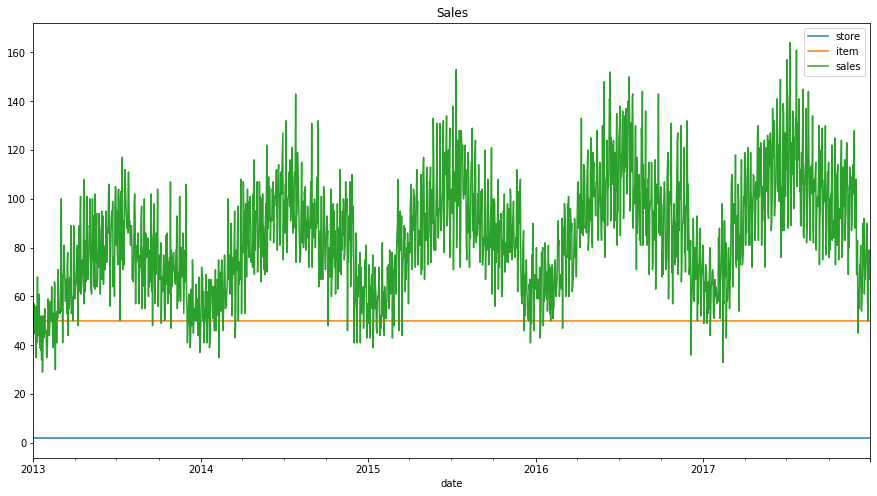

In [23]:
data.plot(figsize = (15,8), title = 'Sales')

In [24]:
# Creating train and test set 
# Train set : 2013 Jan - 2017 June, Test set: 2017 July - Dec 
train=data['2013-01-01':'2017-06-30'] 
test=data['2017-07-01':]
test.tail()

,store,item,sales
date,,,
2017-12-27,2,50,79
2017-12-28,2,50,68
2017-12-29,2,50,67
2017-12-30,2,50,79
2017-12-31,2,50,73


Let's visualise the train and test together to see how they vary over a time period.

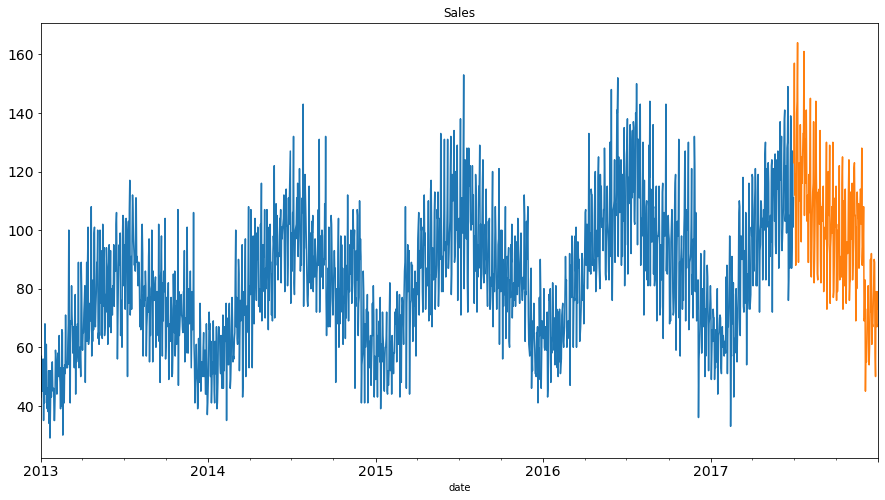

In [17]:
#Plotting data
train.sales.plot(figsize=(15,8), title= 'Sales', fontsize=14)
test.sales.plot(figsize=(15,8), title= 'Sales', fontsize=14)
plt.show()

# Random Walk (Naive)<span style="color:#20419a">
    
Many a times we are provided with a dataset, which is stable throughout it’s time period. If we want to forecast the price for the next day, we can simply take the last day value and estimate the same value for the next day. 
    This is called <b> Naive Method </b>.
    <center>
 $\hat{y}_{t+1} =  $y$_{t}$

Now we will implement the Naive method to forecast the prices for test data.

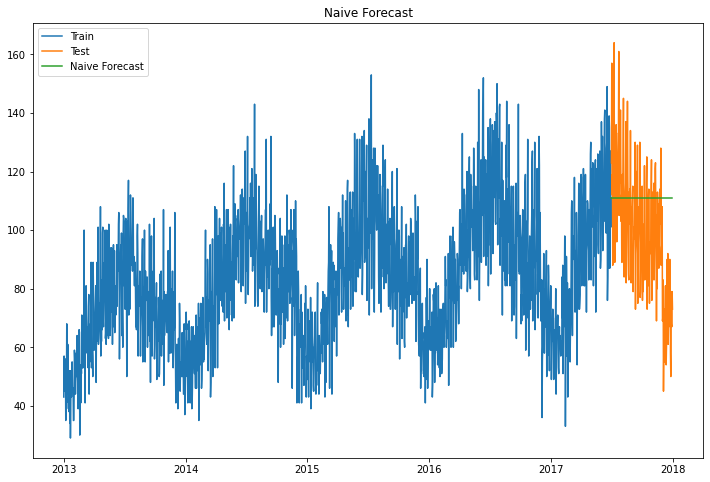

In [25]:
dd= np.asarray(train.sales) # Convert to an array
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1] # Naive forecast y(t+1) = y(t)
plt.figure(figsize=(12,8))
plt.plot(train.index, train['sales'], label='Train')
plt.plot(test.index,test['sales'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [26]:
y_hat.head()

,store,item,sales,naive
date,,,,
2017-07-01,2,50,123,111
2017-07-02,2,50,157,111
2017-07-03,2,50,112,111
2017-07-04,2,50,119,111
2017-07-05,2,50,88,111


In [19]:
# Next we will calculate the RMSE to check accuracy of Naive Model on test data set. 
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.sales, y_hat.naive))
print("RMSE for Naive Method : ", round(rms, 2))

RMSE for Naive Method :  24.99


# Moving Averages

## SMA - Simple Moving Averages

In [27]:
# This time we will reuse the Airline dataset.
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [28]:
airline.dropna(inplace=True)

Create Moving Average 6 months using the `rolling(window)` and `mean` function. 

In [37]:
data.drop(labels = ['6-month-SMA', '12-month-SMA'], inplace = True, axis = 1)

In [38]:
data['30-days-SMA'] = data['sales'].rolling(window=30).mean()

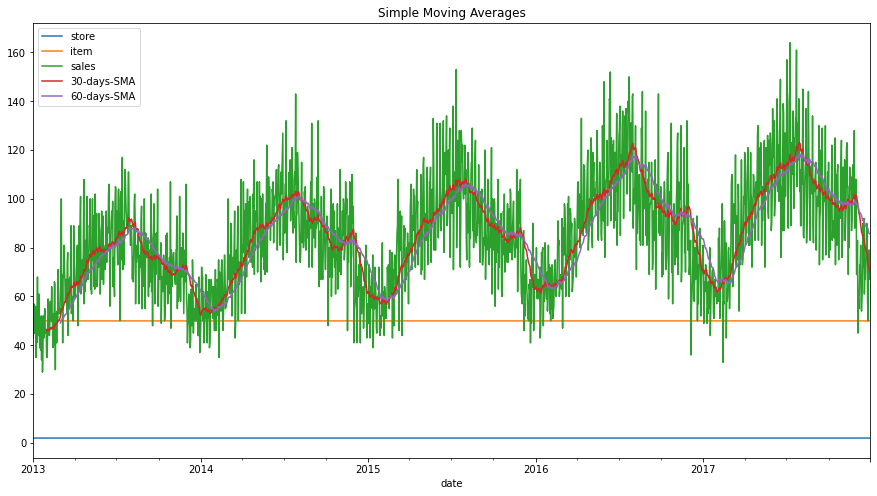

In [39]:
data['60-days-SMA'] = data['sales'].rolling(window=60).mean()
data.plot(title='Simple Moving Averages');

Note that rolling introduces the NaN depending on the window size selected. However there are some disadvantages of simple moving average
- Smaller windows will lead to more noise, rather than signal
- It will always lag by the size of the window (see the MA starts after a certain lag above in the figure)
- It will never reach to full peak or valley of the data due to the averaging.
- Does not really inform you about possible future behavior, all it really does is describe trends in your data.
- Extreme historical values can skew your SMA significantly

To help fix some of these problems, we have the EWMA or the Exponentially Weighted Moving Average

## EWMA - Exponentially Weighted Moving Average
EWMA alows to reduce the lag by putting more weight to the recent readings or values. The <span style="color:blue">amount of weight</span> applied is dependent on the <span style="color:lightgreen">actual parameters in the EWMA</span> and the <span style="color:lightgreen">number of periods given in a window size.</span> 
<p>
More information can be found here <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html">EWM Pandas </a>

Note: EWMA applies Single Exponential Smoothing.Function `ewm`.

In [40]:
data.head()

,store,item,sales,30-days-SMA,60-days-SMA
date,,,,,
2013-01-01,2,50,43,NaN,NaN
2013-01-02,2,50,57,NaN,NaN
2013-01-03,2,50,45,NaN,NaN
2013-01-04,2,50,45,NaN,NaN
2013-01-05,2,50,55,NaN,NaN


In [80]:
data['ewma12'] = data['sales'].ewm(span=365,adjust=False).mean()

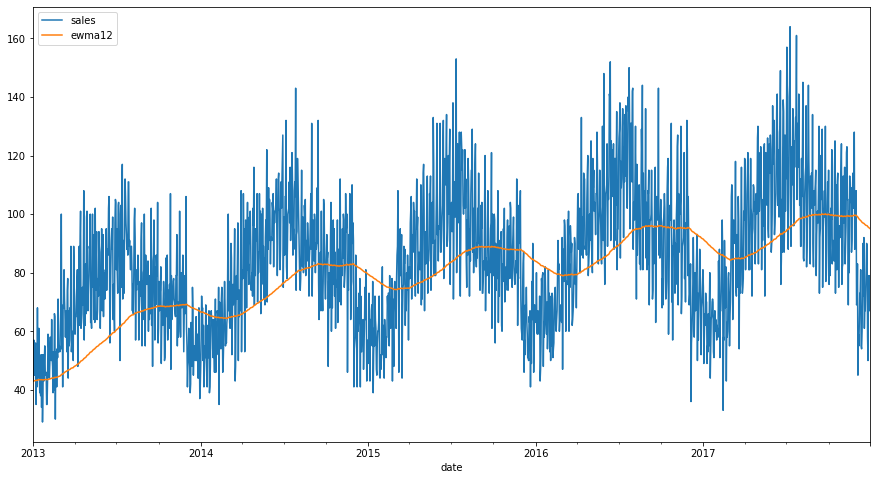

In [81]:
data[['sales','ewma12']].plot();

## Comparing SMA to EWMA

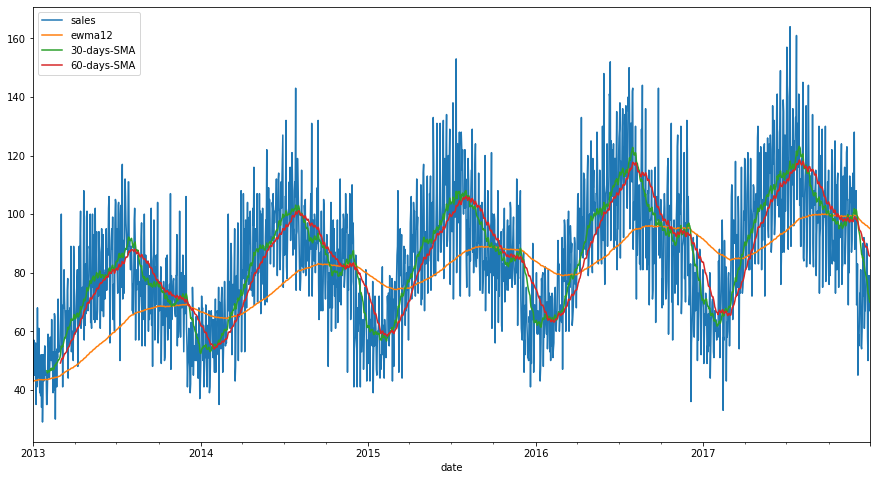

In [82]:
data[['sales','ewma12','30-days-SMA','60-days-SMA']].plot();

## Holt Winters - Simple, Double and Triple Exponential Smoothing

Moving Averages and Single Exponential Smoothing does a poor job of forecasting when there is trend and seasonality in the data. Double and Triple exponential smoothing is best suited for this kind of time-series data. 
<p> Holt winters has all the three variations - <span style="color:red"> Single, Double and Triple exponential smoothing. </span>
<p> Double Exponential smoothing uses a smoothing factor that addresses <span style="color:blue">trend</span>. Triple Exponential smoothing uses a smoothing factor that addresses <span style="color:blue">seasonality.<span>

<p> Span corresponds to what is commonly called an <i>“N-day EW moving average”</i>. Alpha specifies the smoothing factor 
directly.</p>

Refer <a href="https://tedboy.github.io/pandas/computation/computation5.html">link</a>

In [63]:
# set the span and the smoothing factor alpha
span = 365.5
alpha = 2 /(span+1)

To work with forecasting models like Holt Winters, ARIMA, SARIMA etc., the datetime index frequency needs to be set. The Store dataset index indicates dates on the start of the month. Hence we can set this as 'D'

In [64]:
# Set the frequency of the date time index as Daily start as indicated by the data
data.index.freq = 'D' 

In [65]:
data.head()

,store,item,sales,30-days-SMA,60-days-SMA,ewma12,SES12
date,,,,,,,
2013-01-01,2,50,43,NaN,NaN,43.000000,43.000000
2013-01-02,2,50,57,NaN,NaN,43.231405,43.076503
2013-01-03,2,50,45,NaN,NaN,43.260638,43.087014
2013-01-04,2,50,45,NaN,NaN,43.289388,43.097467
2013-01-05,2,50,55,NaN,NaN,43.482952,43.162508


In [71]:
data.tail()

,store,item,sales,30-days-SMA,60-days-SMA,ewma12,SES12,DES12
date,,,,,,,,
2017-12-27,2,50,79,72.666667,86.833333,90.239081,95.505177,71.880206
2017-12-28,2,50,68,71.800000,85.900000,89.871493,95.355081,71.107346
2017-12-29,2,50,67,70.866667,85.750000,89.493452,95.200346,70.197437
2017-12-30,2,50,79,69.900000,85.700000,89.320007,95.111941,72.063467
2017-12-31,2,50,73,70.033333,85.533333,89.050254,NaN,NaN


In [66]:
data.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=1826, freq='D')

## Simple Exponential Smoothing - Using Holt Winters
This is same as `ewm` method in Pandas. For simple exponential smoothing, the function is called `SimpleExpSmoothing`.
Refer examples <a href="https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html">here</a>

In [67]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
data['SES12'] = SimpleExpSmoothing(data['sales']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


NOTE: For some reason, when optimized=False is passed into .fit(), the statsmodels SimpleExpSmoothing function shifts fitted values down one row. We fix this by adding .shift(-1) after .fittedvalues

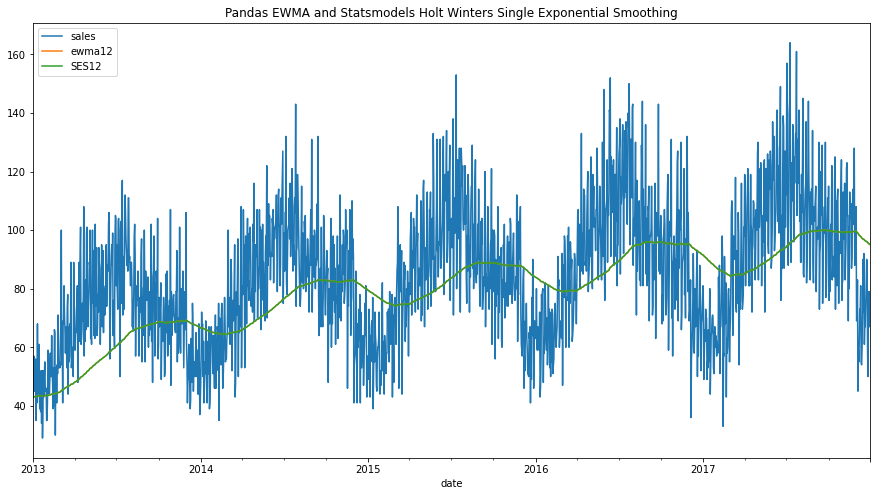

In [83]:
data[['sales','ewma12','SES12']].plot(title='Pandas EWMA and Statsmodels Holt Winters Single Exponential Smoothing');                       

In [62]:
data.head()

,store,item,sales,30-days-SMA,60-days-SMA,ewma12,SES12
date,,,,,,,
2013-01-01,2,50,43,NaN,NaN,43.000000,43.000000
2013-01-02,2,50,57,NaN,NaN,43.231405,43.076503
2013-01-03,2,50,45,NaN,NaN,43.260638,43.087014
2013-01-04,2,50,45,NaN,NaN,43.289388,43.097467
2013-01-05,2,50,55,NaN,NaN,43.482952,43.162508


Both the EWMA and Holt Winters Single Exponential Smoothing curve fit each other completely. 

## Double Exponential Smoothing

In [173]:
data['DES12'] = ExponentialSmoothing(data['sales'], trend='add').fit().fittedvalues.shift(-1)

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


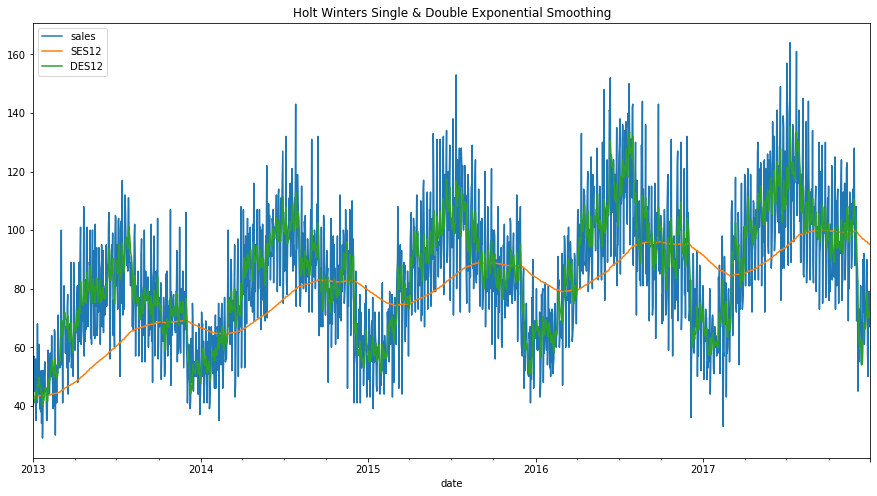

In [158]:
data[['sales','SES12','DES12']].plot(title='Holt Winters Single & Double Exponential Smoothing');

Here the double exponential smoothing completely overlaps on the original data. Let's plot for the last 730 days.

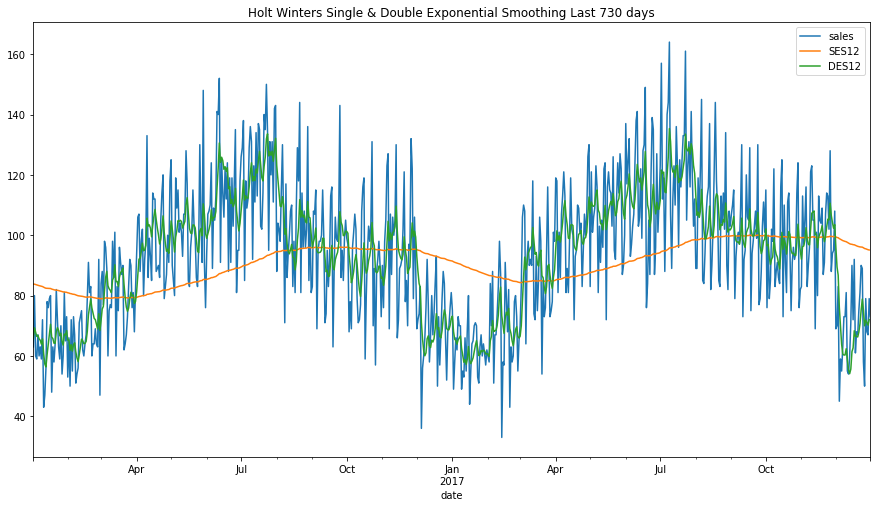

In [159]:
data[['sales','SES12','DES12']].iloc[-730:].plot(title='Holt Winters Single & Double Exponential Smoothing Last 730 days').autoscale(axis='x',tight=True);

Lets replot the above using the multiplicative adjustment instead of additive.

In [171]:
data['DES12_mul'] = ExponentialSmoothing(data['sales'], trend='mul').fit().fittedvalues.shift(-1)

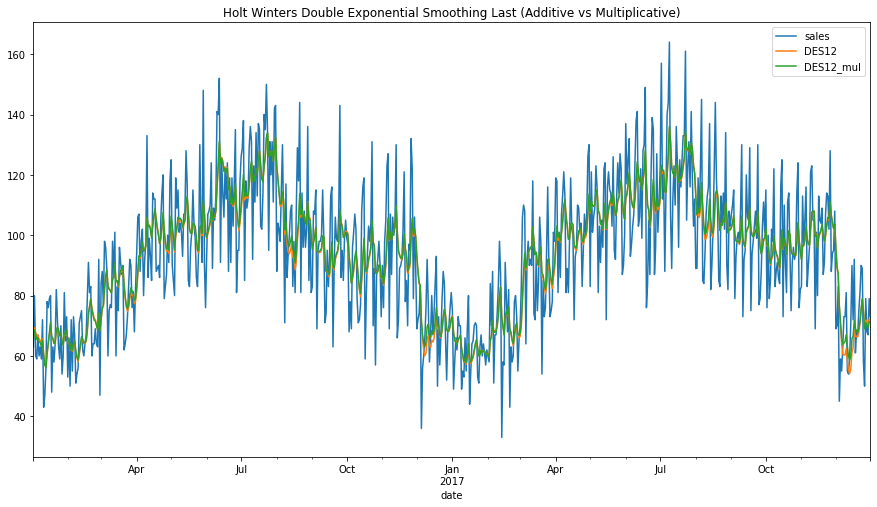

In [172]:
data[['sales','DES12','DES12_mul']].iloc[-730:].plot(title='Holt Winters Double Exponential Smoothing Last (Additive vs Multiplicative)').autoscale(axis='x',tight=True);

Although minor, the multiplicative adjustment gives a better result compared to the additive adjustment for the trend.

## Triple Exponential Smoothing 

In [169]:
data['TESadd12'] = ExponentialSmoothing(data['sales'], trend='add',seasonal='add', seasonal_periods = 7).fit().fittedvalues

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [163]:
data.head()

,store,item,sales,30-days-SMA,60-days-SMA,ewma12,SES12,DES12,DES12_mul,TESadd12,TESmul12
date,,,,,,,,,,,
2013-01-01,2,50,43,NaN,NaN,43.000000,43.000000,40.093024,71.998697,44.886093,NaN
2013-01-02,2,50,57,NaN,NaN,43.076503,43.076398,42.208491,65.627703,43.879891,NaN
2013-01-03,2,50,45,NaN,NaN,43.087014,43.086896,41.565891,58.090338,51.767251,NaN
2013-01-04,2,50,45,NaN,NaN,43.097467,43.097335,41.128326,52.281408,52.556533,NaN
2013-01-05,2,50,55,NaN,NaN,43.162508,43.162289,43.085840,50.049186,57.364833,NaN


In [167]:
data['TESmul12'] = ExponentialSmoothing(data['sales'], trend='mul',seasonal='mul',seasonal_periods=7).fit().fittedvalues

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


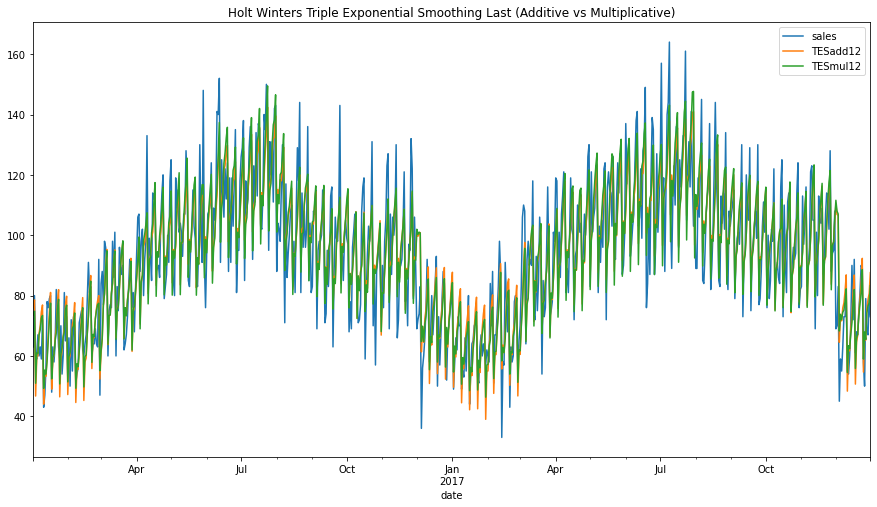

In [168]:
data[['sales','TESadd12','TESmul12']].iloc[-730:].plot(title='Holt Winters Triple Exponential Smoothing Last (Additive vs Multiplicative)').autoscale(axis='x',tight=True);

# Part III - Forecasting with Holt Winters Method

Lets read the sales data again to have a fresh copy

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
store = pd.read_csv("../input/demand_store_forecast/train.csv", parse_dates = True, index_col = 'date')
store.head() 
store.index.freq = 'D' # Set to Daily frequency

In [ ]:
# Filter Store 2, Item # 50
store = store[(store['store'] == 2) & (store['item'] == 50)]

In [ ]:
store.index # Get the index

In [ ]:
store.tail() # Last 5 rows of Store Series

In [ ]:
# Number of months of data (to get test set)
.75*len(store)

### Split into training and test set
It is important to remember that the time-series are dependent on time, hence it is wise to split train test by sequence. 
<span style = "color:#00a19C"> ORDER MATTERS! </span>

In [ ]:
# Split into 75% train and 25% test set. Remember that sequence matters in time-series forecasting!
train_store = store[:1370] 
test_store = store[1370:] 

In [ ]:
len(test_store)

### Fit the model on the train set
Seasonal periods with value <b>365<b> indicates the seasonality we expect in the data. For item sales we can safely assume that the <u>seasonality would repeat every 30 days.</u>

In [ ]:
# Fit Exponential Smoothing
fitted_model = ExponentialSmoothing(train_store['sales'],trend='mul',seasonal='mul', seasonal_periods=365).fit()

In [ ]:
test_predictions = fitted_model.forecast(456).rename('HW Test Forecast')

In [ ]:
test_predictions[:10]

In [ ]:
train_store['sales'].plot(legend=True,label='TRAIN')
test_store['sales'].plot(legend=True,label='TEST',figsize=(12,8))
plt.title('Train and Test Data');

Next we will plot also the predicted test data

In [ ]:
train_store['sales'].plot(legend=True,label='TRAIN')
test_store['sales'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters');

Plot for the recent rows

In [ ]:
train_store['sales'].plot(legend=True,label='TRAIN')
test_store['sales'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION',xlim=['2016-10-12','2018-01-01']);

### Evaluation metrics

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [ ]:
print(f'Mean Absolute Error = {mean_absolute_error(test_store.sales,test_predictions)}')

In [ ]:
print(f'Mean Squared Error = {mean_squared_error(test_store.sales,test_predictions)}')

## END